
#**HR Policy Assistant**

Let’s understand AI-based HR Policy Assistant example to incorporate the four key LangGraph concepts:

* Use chat messages as graph state

* Use llm in graph nodes

* Binding tools to llm

* Executing tool calls in graph nodes



###**Install Dependencies**

In [7]:
# 1. Install LangGraph dependencies
!pip install langgraph langchain langchain-openai


###**Retrive API key from Secrets and Set as an ENV**

In [8]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Set OPENAI_API_KEY as an ENV
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [10]:
# 3. Define policy documents (in-memory store)
policy_documents = {
    "leave_policy": "Employees are entitled to 20 paid leave days per year. Additional unpaid leave can be requested with manager approval.",
    "work_hours": "Regular work hours are from 9 AM to 6 PM, Monday to Friday. Flexible work hours are allowed with prior approval.",
    "remote_work": "Employees can work remotely up to 3 days a week. Full remote work requires special approval.",
}


###**Define Tool**

In [12]:
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

# Tool that looks up policy by keyword
@tool
def lookup_policy(query: str) -> str:
    """
    Matching Policy Retriver
    """
    query = query.lower()
    if "leave" in query:
        return policy_documents["leave_policy"]
    elif "work hours" in query or "timing" in query:
        return policy_documents["work_hours"]
    elif "remote" in query or "work from home" in query:
        return policy_documents["remote_work"]
    else:
        return "Sorry, no matching policy found."

# Bind the tool to the LLM
llm_with_tools = llm.bind_tools([lookup_policy])


###**Define Nodes**

In [35]:
# Nodes will operate on a chat history list

def call_tool_node(state):
    # 1. Extract user's message
    chat_history = state["messages"]
    user_msg = chat_history[-1]

    # 2. LLM decides to call tool
    tool_call = llm_with_tools.invoke(chat_history)
    return {
        "messages": chat_history + [tool_call]
    }

from langchain_core.messages import ToolMessage

def respond_node(state):
    chat_history = state["messages"]

    # Get the last AIMessage
    last_message = chat_history[-1]

    if hasattr(last_message, "tool_calls"):
        tool_messages = []

        for tool_call in last_message.tool_calls:
            # Extract tool input
            query = tool_call["args"]["query"]
            tool_output = lookup_policy.run(query)

            # Create a ToolMessage to send back
            tool_msg = ToolMessage(
                tool_call_id=tool_call["id"],  # must match LLM output tool_call_id
                content=tool_output
            )
            tool_messages.append(tool_msg)

        # Add tool messages to the history
        chat_history.extend(tool_messages)

        # Re-ask the LLM with new messages that include the tool responses
        response = llm.invoke(chat_history)
        chat_history.append(response)

    return {"messages": chat_history}


###**Build and Compile the LangGraph**

In [36]:
from langgraph.graph import StateGraph, END

builder = StateGraph(dict)
builder.add_node("ToolCall", call_tool_node)
builder.add_node("Respond", respond_node)

builder.set_entry_point("ToolCall")
builder.add_edge("ToolCall", "Respond")
builder.add_edge("Respond", END)

graph = builder.compile()


###**Visualize the LangGraph (Optional)**

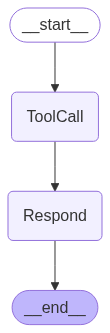

In [37]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [45]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

# Start with a chat state
initial_state = {"messages": [HumanMessage(content="Can I do work from home on Fridays or Should I take a leave?")]}

result = graph.invoke(initial_state)

# Print final LLM response
#print(result["messages"][-1].content)

for message in result["messages"]:
    if isinstance(message, HumanMessage):
        print("🧑 Human:", message.content)
    elif isinstance(message, AIMessage):
        # If the AI made a tool call
        if hasattr(message, "tool_calls") and message.tool_calls:
            print("🤖 AI (Tool Call):", message.tool_calls)
        elif message.content:
            print("🤖 AI:", message.content)
    elif isinstance(message, ToolMessage):
        print(f"🔧 Tool [{message.tool_call_id}]:", message.content)


🧑 Human: Can I do work from home on Fridays or Should I take a leave?
🤖 AI (Tool Call): [{'name': 'lookup_policy', 'args': {'query': 'work from home policy'}, 'id': 'call_gzCwHIgK81hu2XGvb7Y11YgQ', 'type': 'tool_call'}, {'name': 'lookup_policy', 'args': {'query': 'leave policy'}, 'id': 'call_lvMOYu0maiY2Ax9dPnpIDWwp', 'type': 'tool_call'}]
🔧 Tool [call_gzCwHIgK81hu2XGvb7Y11YgQ]: Employees can work remotely up to 3 days a week. Full remote work requires special approval.
🔧 Tool [call_lvMOYu0maiY2Ax9dPnpIDWwp]: Employees are entitled to 20 paid leave days per year. Additional unpaid leave can be requested with manager approval.
🤖 AI: Based on your company's policies, you can work from home on Fridays as part of the remote work policy, which allows for up to 3 days of remote work per week. Therefore, you don't need to take a leave for working from home on Fridays.


**Note:** Here two tool messages. if you change query like `Can I do work from Home?` then only one tool message should be there.